<a href="https://colab.research.google.com/github/siddharth2011/Bot_Detection/blob/main/BERTClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

import torch
from torch import nn
from torch.optim import Adam

from transformers import BertTokenizer, BertModel

## Data prepration

In [3]:
datapath="/content/dataset.csv"

In [4]:
df = pd.read_csv(datapath)
df.head()

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listedcount,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,3.982732e+09,3982731976,mcgucket_bot,NaN,A bot that tweets every line said by Fiddlefor...,NaN,1129,7,2,Sat Oct 17 22:35:31 +0000 2015,0,False,23557,en,"{'retweeted': False, 'is_quote_status': False,...",False,False,False,McGucket bot,1
1,8.410000e+17,8.41E+17,BowieK66,NaN,NaN,NaN,0,22,0,13/03/2017 22:21,0,False,1,en,Status(_api=<tweepy.api.API object at 0x101927...,True,True,False,MJ Kuhn,1
2,2.768375e+09,2768374981,ducknoteprice,NaN,NaN,NaN,3,0,3,Mon Aug 25 23:17:59 +0000 2014,0,False,1050,en,{'created_at': 'Fri Feb 26 17:01:15 +0000 2016...,True,False,False,duckNote,1
3,3.304189e+09,3304189373,robotrecipes,robot kitchen,tasty recipes for robot // not for human // a ...,http://t.co/PdagJGqVMR,505,13,49,Sat May 30 23:42:16 +0000 2015,0,False,5109,en,"{u'contributors': None, u'truncated': False, u...",False,False,False,robot recipes,1
4,3.224289e+09,3224289024,everyumlaut,NaN,bot by @dbaker_h,NaN,15,0,11,Sat May 23 14:39:21 +0000 2015,0,False,31365,en-gb,"{u'contributors': None, u'truncated': False, u...",True,False,False,ÌÇvÌÇrÌÀ Ì_mlÌ_Ì_¼Ñ,1


In [5]:
df.shape

(2232, 20)

In [6]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print('Train Size: ', len(df_train), '| Val Size: ', len(df_val), '|Test Size: ', len(df_test))

Train Size:  1785 | Val Size:  223 |Test Size:  224


In [7]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df, label_encoding):

        self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
        # self.labels = [labels[label] for label in df['bot']]
        self.labels = df['bot'].values
        column_names = df.columns.tolist()
        column_names.remove('bot')
        global_txt_list=[]
        for sublist in df.values.tolist():
            count = 0
            lst=""
            for x in sublist[:len(sublist) - 1]:
                lst = lst + ((column_names[count] + " = " + str(x))) + ", "
                count+=1
            lst= lst[0:len(lst) - 2]
            global_txt_list.append(lst)
        self.texts = [self.tokenizer(txt, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for txt in global_txt_list]
            
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

##Model Building

In [8]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()
        #Defining the model to be used
        self.bert = BertModel.from_pretrained('bert-base-cased') 
        #Adding dropout layer
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [9]:
class Trainer:
    def __init__(self, model, label_encoder, train_data, val_data, learning_rate, epochs):

        self.model = model
        self.label_encoder = label_encoder
        self.train_data = train_data
        self.val_data = val_data
        self.learning_rate = learning_rate
        self.epochs = epochs

    def train(self, ):

        train, val = Dataset(self.train_data, self.label_encoder), Dataset(self.val_data, self.label_encoder)
        self.train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
        self.val_dataloader = torch.utils.data.DataLoader(val, batch_size=2, shuffle=False)

        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")

        criterion = nn.CrossEntropyLoss()
        optimizer = Adam(self.model.parameters(), lr= self.learning_rate)

        if use_cuda:

                self.model = self.model.cuda()
                criterion = criterion.cuda()

        for epoch_num in range(self.epochs):

                total_acc_train = 0
                total_loss_train = 0

                for train_input, train_label in tqdm(self.train_dataloader):

                    train_label = train_label.to(device)
                    mask = train_input['attention_mask'].to(device)
                    input_id = train_input['input_ids'].squeeze(1).to(device)

                    output = self.model(input_id, mask)
                    
                    batch_loss = criterion(output, train_label.long())
                    total_loss_train += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == train_label).sum().item()
                    total_acc_train += acc

                    self.model.zero_grad()
                    batch_loss.backward()
                    optimizer.step()
                
                total_acc_val = 0
                total_loss_val = 0

                with torch.no_grad():
                    for val_input, val_label in self.val_dataloader:
                        val_label = val_label.to(device)
                        mask = val_input['attention_mask'].to(device)
                        input_id = val_input['input_ids'].squeeze(1).to(device)

                        output = self.model(input_id, mask)

                        batch_loss = criterion(output, val_label.long())
                        total_loss_val += batch_loss.item()
                        
                        acc = (output.argmax(dim=1) == val_label).sum().item()
                        total_acc_val += acc
                
                print(
                    f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(self.train_data): .3f} \
                    | Train Accuracy: {total_acc_train / len(self.train_data): .3f} \
                    | Val Loss: {total_loss_val / len(self.val_data): .3f} \
                    | Val Accuracy: {total_acc_val / len(self.val_data): .3f}')
                
    def evaluate(self, test_data):
        test = Dataset(test_data, self.label_encoder)
        test_dataloader = torch.utils.data.DataLoader(test, batch_size=2, shuffle=False)
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")

        if use_cuda:
            self.model = self.model.cuda()
        
        y_true, y_pred = [], []
        total_acc_test = 0
        with torch.no_grad():
            for test_input, test_label in test_dataloader:
                test_label = test_label.to(device)
                mask = test_input['attention_mask'].to(device)
                input_id = test_input['input_ids'].squeeze(1).to(device)
                output = self.model(input_id, mask)
                output = output.argmax(dim=1)
                y_true.extend(list(test_label.cpu().detach().numpy()))
                y_pred.extend(list(output.cpu().detach().numpy()))
        return y_true, y_pred

In [10]:
# Train
labels = {'bot':0, 'human':1}
EPOCHS = 10
model = BertClassifier()
LR = 1e-6

tr = Trainer(model, labels, df_train, df_val, LR, EPOCHS)              
tr.train()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 893/893 [03:24<00:00,  4.36it/s]


Epochs: 1 | Train Loss:  0.490                     | Train Accuracy:  0.548                     | Val Loss:  0.355                     | Val Accuracy:  0.704


100%|██████████| 893/893 [03:23<00:00,  4.39it/s]


Epochs: 2 | Train Loss:  0.284                     | Train Accuracy:  0.792                     | Val Loss:  0.221                     | Val Accuracy:  0.852


100%|██████████| 893/893 [03:22<00:00,  4.40it/s]


Epochs: 3 | Train Loss:  0.177                     | Train Accuracy:  0.896                     | Val Loss:  0.160                     | Val Accuracy:  0.874


100%|██████████| 893/893 [03:23<00:00,  4.40it/s]


Epochs: 4 | Train Loss:  0.127                     | Train Accuracy:  0.920                     | Val Loss:  0.183                     | Val Accuracy:  0.870


100%|██████████| 893/893 [03:23<00:00,  4.40it/s]


Epochs: 5 | Train Loss:  0.099                     | Train Accuracy:  0.941                     | Val Loss:  0.129                     | Val Accuracy:  0.897


100%|██████████| 893/893 [03:22<00:00,  4.40it/s]


Epochs: 6 | Train Loss:  0.080                     | Train Accuracy:  0.946                     | Val Loss:  0.137                     | Val Accuracy:  0.888


100%|██████████| 893/893 [03:22<00:00,  4.40it/s]


Epochs: 7 | Train Loss:  0.060                     | Train Accuracy:  0.964                     | Val Loss:  0.133                     | Val Accuracy:  0.892


100%|██████████| 893/893 [03:22<00:00,  4.41it/s]


Epochs: 8 | Train Loss:  0.042                     | Train Accuracy:  0.978                     | Val Loss:  0.128                     | Val Accuracy:  0.901


100%|██████████| 893/893 [03:22<00:00,  4.40it/s]


Epochs: 9 | Train Loss:  0.034                     | Train Accuracy:  0.983                     | Val Loss:  0.132                     | Val Accuracy:  0.906


100%|██████████| 893/893 [03:22<00:00,  4.40it/s]


Epochs: 10 | Train Loss:  0.020                     | Train Accuracy:  0.993                     | Val Loss:  0.176                     | Val Accuracy:  0.892


In [11]:
# Save Model
torch.save(model, '/content/SWM/BERT_model.pth')

## Inference Evaluation

In [12]:
# Evaluation
y_true_train, y_pred_train = tr.evaluate(df_train)
y_true_test, y_pred_test = tr.evaluate(df_test)

In [24]:
print('Train Accuracy: ', accuracy_score(y_true_train, y_pred_train))
print('Test Accuracy: ', accuracy_score(y_true_test, y_pred_test))

print('\nTrain F1: ', f1_score(y_true_train, y_pred_train))
print('Test F1: ', f1_score(y_true_test, y_pred_test))

print('\nTrain Precision: ', precision_score(y_true_train, y_pred_train))
print('Test Precision: ', precision_score(y_true_test, y_pred_test))

print('\nTrain Recall: ', recall_score(y_true_train, y_pred_train))
print('Test Recall: ', recall_score(y_true_test, y_pred_test))

print('\nTrain AUC Score: ', roc_auc_score(y_true_train, y_pred_train))
print('Test AUC Score: ', roc_auc_score(y_true_test, y_pred_test))

Train Accuracy:  0.9983193277310924
Test Accuracy:  0.8973214285714286

Train F1:  0.9982445874780573
Test F1:  0.8743169398907104

Train Precision:  0.9976608187134502
Test Precision:  0.898876404494382

Train Recall:  0.9988290398126464
Test Recall:  0.851063829787234

Train AUC Score:  0.9983404060502544
Test AUC Score:  0.8909165302782324


Confusion Matrix:



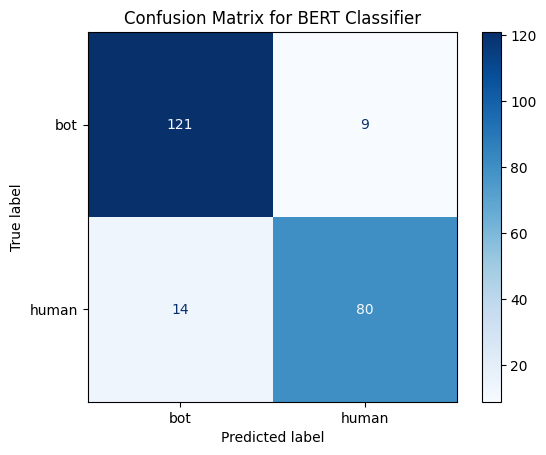

In [14]:
print('Confusion Matrix:\n')
ConfusionMatrixDisplay.from_predictions(y_true_test, y_pred_test, cmap='Blues', colorbar='True',display_labels=labels)
plt.title('Confusion Matrix for BERT Classifier')
plt.show()

ROC Curve:



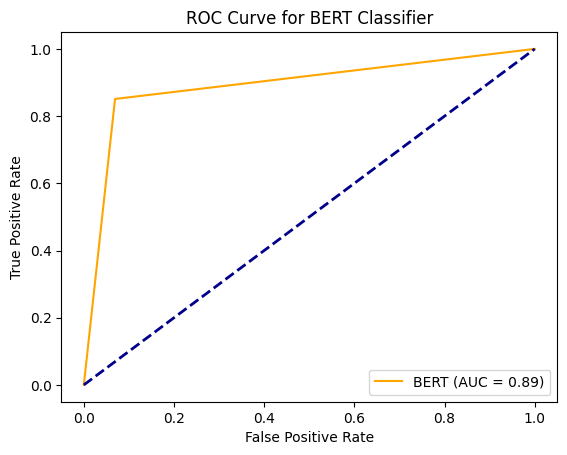

In [22]:
print('ROC Curve:\n')
RocCurveDisplay.from_predictions(y_true_test, y_pred_test, name='BERT', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='darkblue', label='Random guess')
plt.title('ROC Curve for BERT Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Demo

In [16]:
# Define Model
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        #Defining the model to be used
        self.bert = BertModel.from_pretrained('bert-base-cased') 
        #Adding dropout layer
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer

# Load Model
PATH = '/content/SWM/BERT_model.pth'
model = torch.load(PATH)
model.eval()
model.to('cuda')

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Define preprocess function
def pre_process(input):
    column_names = ['id', 'id_str', 'screen_name', 'location', 'description', 'url',
       'followers_count', 'friends_count', 'listedcount', 'created_at',
       'favourites_count', 'verified', 'statuses_count', 'lang', 'status',
       'default_profile', 'default_profile_image', 'has_extended_profile',
       'name', 'bot']
    column_names.remove('bot')
    text = ''
    txt_list=[]
    for i, x in enumerate(input[:len(input) - 1]):
        txt_list.append(column_names[i] + " = " + str(x))

    text = ', '.join(txt_list)
    text = tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
    return text

In [27]:
test_idx = 35
print('Test Index:',test_idx)
input = df_test.iloc[test_idx].values[:-1]
input_gt = df_test.iloc[test_idx].values[-1]
print('Input: ')
print(df_test.iloc[test_idx, :-1].to_dict())
inp = pre_process(input)
label_dict = {0:'not bot', 1: 'Bot'}
outputs = model(inp['input_ids'].to('cuda'), inp['attention_mask'].to('cuda'))
label_idx = np.argmax(outputs.detach().cpu().numpy())
print()
print(f'Model prediction: {label_dict[label_idx]} ---> Ground truth: {label_dict[input_gt]}')

Test Index: 35
Input: 
{'id': 8.25e+17, 'id_str': '8.25E+17', 'screen_name': 'beefl96', 'location': 'Darlington town, IN, USA', 'description': 'Proud West Belconnian, Local Labor member  4 Ginninderra, Minister in the ACT Govt, mum of 2 with Cassie Cupcake K9 Campaigner, Chook lady, Love everything CBR.', 'url': nan, 'followers_count': 0, 'friends_count': 266, 'listedcount': 0, 'created_at': '1/27/2017 0:59', 'favourites_count': 22, 'verified': False, 'statuses_count': 35, 'lang': 'en', 'status': nan, 'default_profile': True, 'default_profile_image': False, 'has_extended_profile': False, 'name': 'beefl96'}

Model prediction: Bot ---> Ground truth: Bot


In [28]:
test_idx = 1
print('Test Index:',test_idx)
input = df_test.iloc[test_idx].values[:-1]
input_gt = df_test.iloc[test_idx].values[-1]
print('Input: ')
print(df_test.iloc[test_idx, :-1].to_dict())
inp = pre_process(input)
label_dict = {0:'not bot', 1: 'Bot'}
outputs = model(inp['input_ids'].to('cuda'), inp['attention_mask'].to('cuda'))
label_idx = np.argmax(outputs.detach().cpu().numpy())
print()
print(f'Model prediction: {label_dict[label_idx]} ---> Ground truth: {label_dict[input_gt]}')

Test Index: 1
Input: 
{'id': 931864753.0, 'id_str': '931864753', 'screen_name': 'dushyanthram', 'location': 'Window seat', 'description': 'Keep talking', 'url': 'https://t.co/vau4LDYgAr', 'followers_count': 86, 'friends_count': 397, 'listedcount': 0, 'created_at': '11/7/2012 11:40', 'favourites_count': 1347, 'verified': False, 'statuses_count': 160, 'lang': 'en', 'status': 'Status(truncated=False, coordinates=None, _api=<tweepy.api.API object at 0x7fbd6ffbd0f0>, in_reply_to_screen_name=None, source=\'Twitter for iPhone\', contributors=None, retweeted=False, entities={\'urls\': [], \'symbols\': [], \'user_mentions\': [{\'name\': \'Not Will Ferrell\', \'id_str\': \'306025835\', \'screen_name\': \'itsWillyFerrell\', \'indices\': [3, 19], \'id\': 306025835}], \'hashtags\': [], \'media\': [{\'url\': \'https://t.co/cEeRyq9IQB\', \'source_user_id_str\': \'306025835\', \'sizes\': {\'large\': {\'resize\': \'fit\', \'h\': 670, \'w\': 460}, \'thumb\': {\'resize\': \'crop\', \'h\': 150, \'w\': 150

In [29]:
# Incorrect Predictions
test_idx = 6
print('Test Index:',test_idx)
input = df_test.iloc[test_idx].values[:-1]
input_gt = df_test.iloc[test_idx].values[-1]
print('Input: ')
print(df_test.iloc[test_idx, :-1].to_dict())
inp = pre_process(input)
label_dict = {0:'not bot', 1: 'Bot'}
outputs = model(inp['input_ids'].to('cuda'), inp['attention_mask'].to('cuda'))
label_idx = np.argmax(outputs.detach().cpu().numpy())
print()
print(f'Model prediction: {label_dict[label_idx]} ---> Ground truth: {label_dict[input_gt]}')

Test Index: 6
Input: 
{'id': 129845242.0, 'id_str': '129845242', 'screen_name': 'Inspire_Us', 'location': nan, 'description': 'The BEST Inspirational Quotes out there!', 'url': 'https://t.co/6RAGS0V2Ek', 'followers_count': 2047969, 'friends_count': 102396, 'listedcount': 13095, 'created_at': 'Mon Apr 05 15:53:40 +0000 2010', 'favourites_count': 860, 'verified': False, 'statuses_count': 67905, 'lang': 'en', 'status': '{\'created_at\': \'Mon Mar 13 19:29:08 +0000 2017\', \'id\': 841370561594953729, \'id_str\': \'841370561594953729\', \'text\': \'No matter how long you have traveled in the wrong direction, you can always turn around.\', \'truncated\': False, \'entities\': {\'hashtags\': [], \'symbols\': [], \'user_mentions\': [], \'urls\': []}, \'source\': \'<a href="https://www.socialoomph.com" rel="nofollow">SocialOomph</a>\', \'in_reply_to_status_id\': None, \'in_reply_to_status_id_str\': None, \'in_reply_to_user_id\': None, \'in_reply_to_user_id_str\': None, \'in_reply_to_screen_name\

In [30]:
# Incorrect Predictions
test_idx = 25
print('Test Index:',test_idx)
input = df_test.iloc[test_idx].values[:-1]
input_gt = df_test.iloc[test_idx].values[-1]
print('Input: ')
print(df_test.iloc[test_idx, :-1].to_dict())
inp = pre_process(input)
label_dict = {0:'not bot', 1: 'Bot'}
outputs = model(inp['input_ids'].to('cuda'), inp['attention_mask'].to('cuda'))
label_idx = np.argmax(outputs.detach().cpu().numpy())
print()
print(f'Model prediction: {label_dict[label_idx]} ---> Ground truth: {label_dict[input_gt]}')

Test Index: 25
Input: 
{'id': 233063518.0, 'id_str': '233063518', 'screen_name': 'GeneP4rmes4n', 'location': nan, 'description': "I'm only on here for my fans", 'url': nan, 'followers_count': 66, 'friends_count': 481, 'listedcount': 0, 'created_at': '2/1/2011 5:03', 'favourites_count': 369, 'verified': False, 'statuses_count': 530, 'lang': 'en', 'status': 'Status(_api=<tweepy.api.API object at 0x10d60c0b8>, _json={\'created_at\': \'Wed Mar 08 00:09:55 +0000 2017\', \'id\': 839266895379460097, \'id_str\': \'839266895379460097\', \'text\': \'RT @colinjones: Episode 2017: The Painting https://t.co/cUykxUM5ZM\', \'truncated\': False, \'entities\': {\'hashtags\': [], \'symbols\': [], \'user_mentions\': [{\'screen_name\': \'colinjones\', \'name\': \'Colin Jones\', \'id\': 17934812, \'id_str\': \'17934812\', \'indices\': [3, 14]}], \'urls\': [], \'media\': [{\'id\': 839149174692151300, \'id_str\': \'839149174692151300\', \'indices\': [43, 66], \'media_url\': \'http://pbs.twimg.com/ext_tw_vide

In [21]:
# # Check incorrect predictions
# for test_idx in range(len(df_test)):
#     input = df_test.iloc[test_idx].values[:-1]
#     input_gt = df_test.iloc[test_idx].values[-1]
#     inp = pre_process(input)
#     label_dict = {0:'not bot', 1: 'Bot'}
#     outputs = model(inp['input_ids'].to('cuda'), inp['attention_mask'].to('cuda'))
#     label_idx = np.argmax(outputs.detach().cpu().numpy())
#     if label_dict[label_idx] != label_dict[input_gt]:
#         print(test_idx)